Abel is a computational neuroscientist who runs virtual mouse brain simulations, he wants to update his mesoconnectome, obtained from the original Oh et al 2014 paper, to a laminar-resolved version. The new version of the common coordinate framework (CCF3.0) has segmented the different layers of cortex and can be used as a basis for these predictions. The CCP first downloads the unionized data for the relevant injection sites. CCP further uses the toolkit from Knox et al, to provide and display a volumetric version of these data.  
References:   
Oh, S.W. et al. A mesoscale connectome of the mouse brain. Nature 508, 207–214 (2014). https://doi.org/10.1038/nature13186    
Knox, J.E. et al. High-resolution data-driven model of the mouse connectome. Network Neuroscience 3(1), 217-236 (2018). https://doi.org/10.1162/netn_a_00066  

Initially a series of data structures, files and functions that are utilized throughout the analysis have to be stored in the current directory space.    

In [1]:
import os
import pickle as pk
from IPython.display import clear_output
from cfg import *

client      = get_bbp_client().document
collab_path = '8650'
ccp_path    = 'CCP v2'
itemlist = client.listdir(os.path.join(collab_path,ccp_path))
for element in itemlist:
    if os.path.isfile('./' + str(element)) == True: continue
    if 'Library.py' in element: continue
    print 'element {} has been downloaded'.format(element)
    local_path = './' + element
    client.download_file(os.path.join(collab_path,ccp_path, element),local_path)
    clear_output()

The cfg.py file is used for updating and importing all useful libraries to be used throughout the analysis.
Moreover, all functions/classes inside cfg.py (find_notebook, NotebookLoader, NotebookFinder) were taken from a tutorial on how to import external jupyter notebooks as modules.  
Documentations about the aforementioned functions and classes can be found in this link:  
https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  
The code below is responsible for downloading the aforementioned data from the storage space.  

In this step a series of libraries whose classes and functions have to be utilized throughout the analysis, are being downloaded from the storage space and imported as modules.

In [2]:
element = 'PrimaryLibrary.ipynb'
local_path = './' + element
client.download_file(os.path.join(collab_path, element),local_path)

import PrimaryLibrary as PL
imp.reload(PL)

clear_output()

In this cell, an initialization of an sbaInterface_class instance is made. The sbaInterface_class serves as an API for calling the Scalable Brain Composer (SBA)  brain visualization tool. As shown by the steps below, we will use the SBA for a series of visualizations.  
As soon as the initialization is being made, a window will pop-up. On later steps, values will be passed to SBA which will lead to visualizations displayed in the aforementioned window.

In [3]:
# SBA Composer page to load: here it is the -dev version and atlas ABA_v3
sbaHost = 'https://scalablebrainatlas.incf.org/composer-dev';
sbaUrl  = sbaHost+'/?template=ABA_v3';

sbaInterface = PL.sbaInterface_class(sbaUrl,sbaHost)

### Step 1: Data/Parameter Intialization   
Before start of the analysis, an instance of class MesoconnectomePredictor is created (MesoPred) in order to utilize the function for building the layer resolved array.

In [4]:
MesoPred = PL.MesoconnectomePredictor()

### Step 2: Create a layer-resolved connectivity array   
The GetLayerResolvedArray function from MesoPred is being called. This function has two modes with take as input two possible structures, respectively: 
1. unionized for connectivity estimates over anatomically distinct brain areas.
2. voxelized for connectivity estimates over voxels of 100 micrometer cubed.     

This function downloads tract tracing experiments from the Allen Institute for Brain Science and utilizes the mouse connectivity models toolbox developed at the same institute in order to construct a 3D array of type:
1. laminar resolved profiles x source x target brain areas for the unionized mode.
2. laminar resolved profiles x source x target brain voxels for the voxelized mode.

An example of laminar resolved profiles would be L5 PT derived from projections from layer 5 and pyramidal tract specific neuronal populations.

In [5]:
layer_resolved_array, model_meta = MesoPred.GetLayerResolvedArray(mode = 'unionized')
#layer_resolved_array = pk.load(open('layer_resolved_array.pkl','rb'))
#model_meta           = pk.load(open('model_meta.pkl','rb'))
clear_output()

### Step 3: Array Visualization    
Let's assume that given the newly created array, Abel wants to visualize projections from MOp (primary motor cortex area).   
Let's further assume that he is interested in layer 6 corticothalamic projections.  
In the above script, such a projection is being selected.

In [6]:
ROI = 'MOp1'
sel_profile = [idx for idx,val in enumerate(model_meta['layer profiles']) if val == 'L6 CT'][0]

In [7]:
selected_source = [idx for idx, val in enumerate(model_meta['source id']) if ROI in val][0]

In this step furthermore, the volume of the selected projection across the mouse brain is being visually inspected with three different approaches:
*  Brain slice visualization with the use of the BrainPlotter tool.
*  3D brain visualization with the use of the Scalable Brain Composer (SBA) tool.
*  Cortical flatmap visualization the use of the BrainPlotter tool.

#### Brain Slice visualization

In [8]:
target_indices = [id2 for val in model_meta['target id'] for id2,val2 in enumerate(MesoPred.targetprofiles['str_acronym']) if val == val2]
source_indices = [id2 for val in model_meta['source id'] for id2,val2 in enumerate(MesoPred.targetprofiles['str_acronym']) if val == val2]

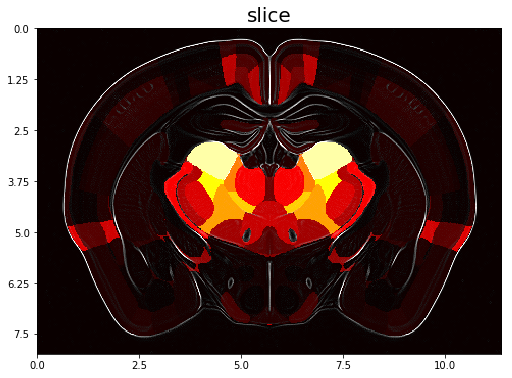

In [9]:
BP_25 = PL.BrainPlotter(resolution = 25)
BP_25.fit(projection = layer_resolved_array[sel_profile,:,selected_source], 
          chosen_indices = target_indices)
BP_25.plot_slice()

#### Call to the SBA tool   
When SBA is being called, a green pop-up window will show up. If the user clicks on "Re-open SBA Composer" the results will be displayed on the window that was opened during the first steps.   
The user can navigate through the various parts of the mouse brain for visual inspection, by utilizing the buttons on the right part of the screen.  
A tutorial for the tool is being provided by clicking at the Readme & FAQ button at the left top of the screen. 

In [10]:
sbaCommand        = BP_25.Call_SBA(InputData = BP_25.pd, mode = 'nifti')
sbaInterface.send(sbaCommand)
clear_output()

#### Cortical flatmap visualization

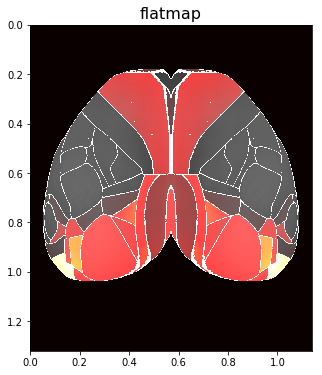

In [11]:
BP_10 = PL.BrainPlotter(resolution = 10)
BP_10.fit(projection = layer_resolved_array[sel_profile,:,selected_source], 
          chosen_indices = target_indices)
BP_10.plot_flatmap()

### Step 4: Export to csv   
Last but not least, the array is being converted in .csv format and uploaded to the storage in case that the user wants to store it in an archive.

In [14]:
exportFile = 'unionized_layer_specific_matrix.csv'
itemlist = client.listdir(collab_path)
if os.path.isdir(os.path.join('./', 'csv_results')) == False:
    !mkdir csv_results
for profile_idx, sel_profile in enumerate(model_meta['layer profiles']):
    print 'exporting ' + str(sel_profile) + ' in .csv format'
    if '/' in sel_profile: sel_profile = sel_profile.replace('/','_')
    new_exportFile = exportFile.split('.')[0] + '_'+ sel_profile + '.csv'
    if new_exportFile not in itemlist:
        path = os.path.join('csv_results',new_exportFile)
        layer_resolved_df = pd.DataFrame(layer_resolved_array[profile_idx,:,:],\
                                         index = model_meta['target id'],\
                                         columns = model_meta['source id'])
        layer_resolved_df.to_csv(path_or_buf = path)
        client.upload_file(path, os.path.join(collab_path, new_exportFile))

exporting L5 IT in .csv format
exporting L2/3 IT in .csv format
exporting L5 PT in .csv format
exporting L4/5 IT in .csv format
exporting L6 CT in .csv format
exporting layer inspecific in .csv format
exporting L4 IT in .csv format
exporting L5 IT PT CT in .csv format


### Step 5: Volumetric version   
As a last step, the volumetric version can be acquired by using the command below.  
Given the huge dimensionality of the output array, no visualizations will be provided.    
However the data can be exported in .csv format and visualized as shown
in the previous steps.

In [ ]:
layer_resolved_vol_array, model_meta = MesoPred.GetLayerResolvedArray(mode = 'voxelized')
clear_output()
print layer_resolved_vol_array.shape

Current analyzed cre lines are: L5 IT -> ['Tlx3-Cre_PL56']
Current analyzed cre lines are: L2/3 IT -> ['Cux2-IRES-Cre', 'Sepw1-Cre_NP39']
Current analyzed cre lines are: L5 PT -> ['A930038C07Rik-Tg1-Cre', 'Chrna2-Cre_OE25', 'Efr3a-Cre_NO108', 'Sim1-Cre_KJ18']
Current analyzed cre lines are: L4/5 IT -> ['Scnn1a-Tg3-Cre', 'Rorb-IRES2-Cre']
Current analyzed cre lines are: L6 CT -> ['Ntsr1-Cre_GN220', 'Syt6-Cre_KI148']
Current analyzed cre lines are: layer inspecific -> ['C57BL/6J', 'Emx1-IRES-Cre']
Current analyzed cre lines are: L4 IT -> ['Nr5a1-Cre']
Current analyzed cre lines are: L5 IT PT CT -> ['Rbp4-Cre_KL100']
